<a href="https://colab.research.google.com/github/jasmineyyip/sql-latency-predictor/blob/main/SQLLatencyPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Set Up

In [76]:
pip install pandas scikit-learn xgboost matplotlib

In [77]:
pip install sqlite-utils

###Database & Query Generation
*  Use SQLite to create synthetic tables
*  Populate with Synthetic Data

In [78]:
import sqlite3

conn = sqlite3.connect("latency_project.db")
cursor = conn.cursor()

# create synthetic tables
cursor.execute("DROP TABLE IF EXISTS Customers")
cursor.execute("""
CREATE TABLE Customers (
    CustomerID INTEGER PRIMARY KEY,
    Name TEXT,
    Age INTEGER,
    Country TEXT
)
""")

cursor.execute("DROP TABLE IF EXISTS Orders")
cursor.execute("""
CREATE TABLE Orders (
    OrderID INTEGER PRIMARY KEY,
    CustomerID INTEGER,
    Amount REAL,
    OrderDate TEXT,
    FOREIGN KEY(CustomerID) REFERENCES Customers(CustomerID)
)
""")

conn.commit()

In [79]:
import random

names = ['Alice', 'Bob', 'Charlie', 'Diana']
countries = ['USA', 'Canada', 'Germany']

customers = [(i, random.choice(names), random.randint(18, 70), random.choice(countries)) for i in range(1, 10001)]
orders = [(i, random.randint(1, 10000), round(random.uniform(10, 1000), 2),
           f"2022-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}") for i in range(1, 20001)]

cursor.executemany("INSERT INTO Customers VALUES (?, ?, ?, ?)", customers)
cursor.executemany("INSERT INTO Orders VALUES (?, ?, ?, ?)", orders)
conn.commit()

### Generate SQL Queries & Measure Latency
*   Create Python code to randomly generate SQL queries of different structure



In [80]:
import time

def run_and_time_query(query):
    start = time.time()
    cursor.execute(query)
    _ = cursor.fetchall()
    end = time.time()
    return (end - start) * 1000  # ms

query = """
SELECT Customers.Name, SUM(Orders.Amount)
FROM Customers
JOIN Orders ON Customers.CustomerID = Orders.CustomerID
WHERE Age > 30 AND Country = 'USA'
GROUP BY Customers.CustomerID
"""
latency_ms = run_and_time_query(query)

###Extracrt Query Features

In [81]:
import re
import pandas as pd
import time
import sqlite3

# connect to SQLite DB
conn = sqlite3.connect("latency_project.db")
cursor = conn.cursor()

query_templates = [
    "SELECT * FROM Customers WHERE Age > {age}",
    "SELECT * FROM Orders WHERE Amount < {amount}",
    "SELECT Customers.Name, Orders.Amount FROM Customers JOIN Orders ON Customers.CustomerID = Orders.CustomerID WHERE Age > {age} AND Country = '{country}'",
    "SELECT Customers.Country, COUNT(*) FROM Customers GROUP BY Country",
    "SELECT AVG(Orders.Amount) FROM Orders WHERE OrderDate > '2022-{month:02d}-01'",
    "SELECT Orders.OrderID, Orders.Amount FROM Orders JOIN Customers ON Orders.CustomerID = Customers.CustomerID WHERE Country = '{country}' AND Age BETWEEN {age1} AND {age2}",
]

import random

# generate 100 synthetic queries with random combinations
def generate_random_query():
    template = random.choice(query_templates)
    return template.format(
        age=random.randint(20, 60),
        amount=random.randint(50, 900),
        country=random.choice(['USA', 'Canada', 'Germany']),
        month=random.randint(1, 12),
        age1=random.randint(20, 40),
        age2=random.randint(41, 70)
    )

queries = [generate_random_query() for _ in range(100)]

In [82]:
def estimate_rows(query: str) -> int:
    try:
        count_query = re.sub(r"(?i)select\s+.+?\s+from", "SELECT COUNT(*) FROM", query, count=1)
        cursor.execute(count_query)
        result = cursor.fetchone()
        return result[0] if result else 0
    except Exception as e:
        print(f"Count estimation failed: {e}")
        return -1

In [83]:
def extract_features(query):
    num_joins = len(re.findall(r'\bJOIN\b', query, flags=re.IGNORECASE))
    num_filters = len(re.findall(r'\b(WHERE|AND|OR)\b', query, flags=re.IGNORECASE))
    uses_group_by = int(bool(re.search(r'\bGROUP BY\b', query, flags=re.IGNORECASE)))
    uses_aggregation = int(bool(re.search(r'\b(SUM|AVG|COUNT|MIN|MAX)\b', query, flags=re.IGNORECASE)))
    query_length = len(query.split())
    estimated_rows = estimate_rows(query)

    return {
        "num_joins": num_joins,
        "num_filters": num_filters,
        "uses_group_by": uses_group_by,
        "uses_aggregation": uses_aggregation,
        "query_length": query_length,
        "estimated_rows": estimated_rows,
    }

# run queries and record their latencies
def run_and_time_query(query):
    start = time.time()
    try:
        cursor.execute(query)
        _ = cursor.fetchall()
    except Exception as e:
        print(f"Query failed: {e}")
        return None
    end = time.time()
    return (end - start) * 1000  # ms

In [84]:
# build dataset
data = []
for query in queries:
    latency = run_and_time_query(query)
    if latency is not None:
        features = extract_features(query)
        features["latency_ms"] = latency
        data.append(features)

# create DataFrame
df = pd.DataFrame(data)
print(df.head())

   num_joins  num_filters  uses_group_by  uses_aggregation  query_length  \
0          0            1              0                 0             8   
1          0            0              1                 1             8   
2          0            1              0                 1             8   
3          0            1              0                 0             8   
4          0            1              0                 0             8   

   estimated_rows  latency_ms  
0           13586   38.717031  
1            3365    6.847858  
2           13229    3.824949  
3            2445    7.158518  
4            8178   20.765066  


###Train a Latency Prediction Model

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# prepare features and labels
X = df.drop(columns=["latency_ms"])
y = df["latency_ms"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model with random forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.3f} ms")
print(f"RMSE: {rmse:.3f} ms")

R² Score: 0.663
MAE: 3.903 ms
RMSE: 6.900 ms


###Simulate Workload Drift

In [86]:
# phase A and phase B query templates
phase_A_templates = [
    "SELECT * FROM Customers WHERE Age > {age}",
    "SELECT * FROM Orders WHERE Amount < {amount}",
    "SELECT Orders.OrderID FROM Orders WHERE OrderDate > '2022-{month:02d}-01'"
]

phase_B_templates = [
    "SELECT Customers.Name, Orders.Amount FROM Customers JOIN Orders ON Customers.CustomerID = Orders.CustomerID WHERE Age > {age} AND Country = '{country}'",
    "SELECT Customers.Country, COUNT(*) FROM Customers GROUP BY Country",
    "SELECT AVG(Orders.Amount) FROM Orders WHERE OrderDate > '2022-{month:02d}-01'",
    "SELECT Orders.OrderID, Orders.Amount FROM Orders JOIN Customers ON Orders.CustomerID = Customers.CustomerID WHERE Country = '{country}' AND Age BETWEEN {age1} AND {age2}"
]

# generate a query with placeholders
def generate_query(template):
    return template.format(
        age=random.randint(20, 60),
        amount=random.randint(50, 900),
        country=random.choice(['USA', 'Canada', 'Germany']),
        month=random.randint(1, 12),
        age1=random.randint(20, 40),
        age2=random.randint(41, 70)
    )

# generate phase A and phase B queries
queries_A = [generate_query(random.choice(phase_A_templates)) for _ in range(50)]
queries_B = [generate_query(random.choice(phase_B_templates)) for _ in range(50)]

data_A, data_B = [], []

for q in queries_A:
    latency = run_and_time_query(q)
    if latency is not None:
        f = extract_features(q)
        f['latency_ms'] = latency
        f['phase'] = 'A'
        data_A.append(f)

for q in queries_B:
    latency = run_and_time_query(q)
    if latency is not None:
        f = extract_features(q)
        f['latency_ms'] = latency
        f['phase'] = 'B'
        data_B.append(f)

# combine into one dataset
df_all = pd.DataFrame(data_A + data_B)

In [87]:
summary_stats = df_all.groupby('phase')[['num_joins', 'num_filters', 'uses_group_by', 'uses_aggregation', 'query_length', 'latency_ms']].mean().round(2)
summary_stats

,num_joins,num_filters,uses_group_by,uses_aggregation,query_length,latency_ms
phase,,,,,,
A,0.0,1.00,0.00,0.0,8.00,21.96
B,0.5,1.58,0.26,0.5,14.18,22.63


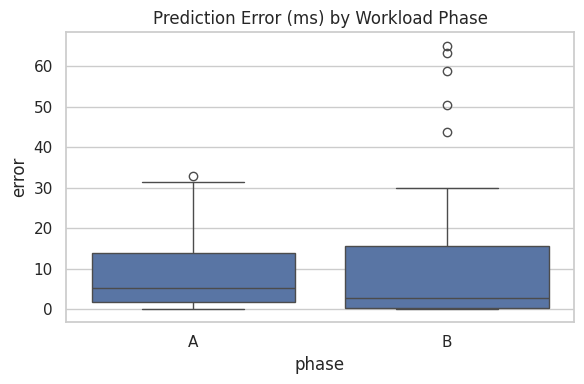

In [88]:
# get prediction errors
df_all_pred = df_all.copy()
df_all_pred["y_true"] = df_all["latency_ms"]
df_all_pred["y_pred"] = model.predict(df_all.drop(columns=["latency_ms", "phase"]))
df_all_pred["error"] = abs(df_all_pred["y_true"] - df_all_pred["y_pred"])

# plot error by phase
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_all_pred, x="phase", y="error")
plt.title("Prediction Error (ms) by Workload Phase")
plt.tight_layout()
plt.show()

##Inference Phase

In [89]:
new_query = """
SELECT COUNT(*)
FROM Customers
JOIN Orders ON Customers.CustomerID = Orders.CustomerID
WHERE Age > 35 AND Country = 'USA'
"""

In [90]:
features = extract_features(new_query)
X_new = pd.DataFrame([features])

In [91]:
predicted_latency = model.predict(X_new)[0]
print(f"Predicted Latency: {predicted_latency:.2f} ms")

Predicted Latency: 5.04 ms


In [100]:
actual_latency = run_and_time_query(new_query)
print(f"Actual Latency: {actual_latency:.2f} ms")

Actual Latency: 10.96 ms
